In [26]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re, datetime
import matplotlib.pyplot as plt

from multiprocessing import Pool
num_processors = 8


In [2]:
use_kmers = False
N1 = 64
N2 = 32
lr = 0.002
batch_size = 64 if use_kmers else 32

In [3]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
fn_load_prefix = 'RegressData/Regress_data_6143genes_19cells_'

# Load datasets
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
# save_vars = ['rnau','genes']
for var in save_vars:
    fn = fn_load_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn)
    exec(cmd)
    print('Loaded %s' % fn)

if use_kmers:
    with np.load(fn_load_prefix+'kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    kmer_countsu = kmer_countsu/kmer_countsu.shape[1]/100
    
    # Testing:
    kmer_countsu = kmer_countsu[:,:2]
    
    print('Kmers shape: ', kmer_countsu.shape)
    Nk=kmer_countsu.shape[1]
    print('Loaded kmers')
else:
    Nk=0

Loaded RegressData/Regress_data_6143genes_19cells_genes2enhu.pkl
Loaded RegressData/Regress_data_6143genes_19cells_rnau.pkl
Loaded RegressData/Regress_data_6143genes_19cells_df_mlevelu.pkl
Loaded RegressData/Regress_data_6143genes_19cells_df_atacu.pkl
Loaded RegressData/Regress_data_6143genes_19cells_genes.pkl


In [4]:
with np.load(fn_load_prefix+'AllLookups.npz',allow_pickle=True) as data:
    ml_lookup=data['ml_lookup']
    atac_lookup=data['atac_lookup']
    rna_lookup=data['rna_lookup']
    kmeri_lookup=data['kmeri_lookup']

In [5]:
# 1. Simplest model. Find the most predictive single enhancer for each gene.
from scipy.stats import zscore

ngenes = rna_lookup.shape[0]
ncells = rna_lookup.shape[1]
W_enh_gene = np.zeros((ngenes,ncells))

# x = f_mcg(ml_lookup) * f_atac(atac_lookup)
x = ml_lookup.copy()
y = rna_lookup.copy()

In [24]:
# For each gene find the correlation with each enhancer
from scipy.stats import spearmanr

def myCorr(x,y,doshuff=False,jshuff=0):    
    t0 = time.time()
    tot_time = 0;
    ngenes,nenh,ncells = x.shape
    xy_cc = np.zeros((ngenes, nenh))+np.nan
    use_enh = np.sum(x!=0,axis=2)
    
    if doshuff:
        # Randomize both the cell order and the gene order
        y=y[:,np.random.permutation(ncells)]
        y=y[np.random.permutation(ngenes),:]

    for j in range(nenh):
        curr_genes = use_enh[:,j]>0
        xy_cc[curr_genes,j] = [np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(x[curr_genes,j,:], y[curr_genes,:])]
#         xy_cc[curr_genes,j] = [spearmanr(x1,y1)[0] for (x1,y1) in zip(x[curr_genes,j,:], y[curr_genes,:])]
        
        if ((time.time()-t0)>5) or (j==nenh-1):
            tot_time+=(time.time()-t0)
            print('%d/%d. Shuff %d. %d enhancers. t=%3.3f s' % (j,nenh,jshuff,np.sum(curr_genes),tot_time))
            t0=time.time()
        
    return xy_cc

In [25]:
r,p = spearmanr(np.random.randn(10,19),np.random.randn(10,19),axis=0)
r.shape

(38, 38)

In [23]:
# Get correlation for real data
xy_cc = myCorr(x,y)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


1/1030. Shuff 0. 6143 enhancers. t=6.415 s
3/1030. Shuff 0. 5879 enhancers. t=12.252 s
5/1030. Shuff 0. 5545 enhancers. t=17.795 s
7/1030. Shuff 0. 5100 enhancers. t=22.919 s
10/1030. Shuff 0. 4346 enhancers. t=29.686 s
13/1030. Shuff 0. 3643 enhancers. t=35.405 s
17/1030. Shuff 0. 2952 enhancers. t=41.709 s
22/1030. Shuff 0. 2229 enhancers. t=47.806 s
28/1030. Shuff 0. 1708 enhancers. t=53.456 s
35/1030. Shuff 0. 1335 enhancers. t=58.534 s
44/1030. Shuff 0. 1031 enhancers. t=63.637 s
56/1030. Shuff 0. 728 enhancers. t=68.713 s
74/1030. Shuff 0. 482 enhancers. t=73.882 s
103/1030. Shuff 0. 260 enhancers. t=78.927 s
177/1030. Shuff 0. 63 enhancers. t=83.946 s
1029/1030. Shuff 0. 1 enhancers. t=86.476 s


In [27]:
# Get correlation for shuffled data. Run in parallel
nshuff = 50
np.random.seed(0)

#Create a pool of processors
t0=time.time()
with Pool(processes = num_processors) as p:
    xy_cc_shuff = p.starmap(myCorr, [(x,y,True,jshuff) for jshuff in range(nshuff)])
print('All done, t=%3.3f', time.time()-t0)

xy_cc_shuff = np.dstack(xy_cc_shuff)

9/1030. Shuff 0. 4584 enhancers. t=5.182 s
9/1030. Shuff 2. 4584 enhancers. t=5.444 s
5/1030. Shuff 4. 5545 enhancers. t=5.455 s
19/1030. Shuff 0. 2588 enhancers. t=10.275 s
5/1030. Shuff 6. 5545 enhancers. t=5.699 s
5/1030. Shuff 8. 5545 enhancers. t=5.077 s
18/1030. Shuff 2. 2802 enhancers. t=10.683 s
4/1030. Shuff 10. 5735 enhancers. t=5.712 s
12/1030. Shuff 4. 3889 enhancers. t=10.661 s
4/1030. Shuff 12. 5735 enhancers. t=5.573 s
37/1030. Shuff 0. 1243 enhancers. t=15.380 s
12/1030. Shuff 6. 3889 enhancers. t=11.121 s
12/1030. Shuff 8. 3889 enhancers. t=10.446 s
4/1030. Shuff 14. 5735 enhancers. t=5.303 s
35/1030. Shuff 2. 1335 enhancers. t=15.772 s
24/1030. Shuff 4. 2045 enhancers. t=15.979 s
11/1030. Shuff 10. 4114 enhancers. t=11.243 s
81/1030. Shuff 0. 411 enhancers. t=20.442 s
23/1030. Shuff 6. 2138 enhancers. t=16.157 s
11/1030. Shuff 12. 4114 enhancers. t=11.047 s
23/1030. Shuff 8. 2138 enhancers. t=15.476 s
11/1030. Shuff 14. 4114 enhancers. t=10.777 s
74/1030. Shuff 2. 482

41/1030. Shuff 31. 1124 enhancers. t=20.889 s
1029/1030. Shuff 23. 1 enhancers. t=29.002 s
4/1030. Shuff 34. 5735 enhancers. t=5.222 s
1029/1030. Shuff 25. 1 enhancers. t=28.734 s
89/1030. Shuff 27. 345 enhancers. t=26.141 s
10/1030. Shuff 32. 4346 enhancers. t=10.744 s
98/1030. Shuff 29. 290 enhancers. t=26.235 s
4/1030. Shuff 36. 5735 enhancers. t=5.233 s
89/1030. Shuff 31. 345 enhancers. t=25.912 s
1029/1030. Shuff 27. 1 enhancers. t=29.479 s
1029/1030. Shuff 29. 1 enhancers. t=29.043 s
11/1030. Shuff 34. 4114 enhancers. t=10.847 s
19/1030. Shuff 32. 2588 enhancers. t=15.746 s
4/1030. Shuff 38. 5735 enhancers. t=5.453 s
1029/1030. Shuff 31. 1 enhancers. t=29.193 s
10/1030. Shuff 36. 4346 enhancers. t=10.300 s
4/1030. Shuff 40. 5735 enhancers. t=5.331 s
21/1030. Shuff 34. 2330 enhancers. t=16.123 s
4/1030. Shuff 42. 5735 enhancers. t=5.379 s
36/1030. Shuff 32. 1292 enhancers. t=20.901 s
10/1030. Shuff 38. 4346 enhancers. t=10.680 s
4/1030. Shuff 44. 5735 enhancers. t=5.128 s
20/1030.

In [28]:
xy_cc_shuff.shape, xy_cc.shape

((6143, 1030, 50), (6143, 1030))

In [29]:
best_enh = np.argmax(np.abs(xy_cc),axis=1)
best_cc = np.nanmax(np.abs(xy_cc),axis=1)

best_cc_shuff = np.nanmax(np.abs(xy_cc_shuff),axis=1,keepdims=True)
best_cc_shuff_mean = best_cc_shuff.mean(axis=2)
best_cc_shuff_sd = best_cc_shuff.std(axis=2)
best_cc_shuff_max = best_cc_shuff.max(axis=2)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Text(0, 0.5, 'Density of genes')

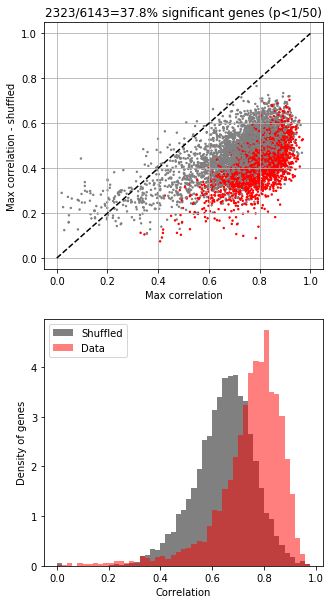

In [31]:
from matplotlib.colors import ListedColormap

fig,axs=plt.subplots(2,1,figsize=(5,10))
plt.sca(axs[0])
sig = best_cc>(best_cc_shuff_mean+3*best_cc_shuff_sd).squeeze()
# sig = best_cc>(best_cc_shuff_mean+best_cc_shuff_max).squeeze()
plt.scatter(best_cc, best_cc_shuff_mean,
            s=2,c=sig,
            cmap = ListedColormap(["gray",'red']))
plt.plot([0,1],[0,1],'k--')
plt.grid()
plt.xlabel('Max correlation')
plt.ylabel('Max correlation - shuffled')
plt.title('%d/%d=%3.1f%% significant genes (p<1/%d)' % (sig.sum(),ngenes,
                                                        100*sig.sum()/ngenes, nshuff))

plt.sca(axs[1])
plt.hist(best_cc_shuff.max(axis=2), bins=np.arange(0,1,0.02),density=True,color='gray',label='Shuffled');
plt.hist(best_cc, bins=np.arange(0,1,0.02),density=True,color='red',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Density of genes')

In [6]:
data = get_data_index(np.arange(5))
data['epi'].shape # G genes x E enhancers x C celltypes x K modalities
data['y'].shape   # G genes x C celltypes

(5, 19)

In [7]:
def f_mcg(x):
    m0 = 0.2
    out = np.exp(-x/m0)
    return out

def f_atac(x):
    a0 = 0.1
    return x + a0

In [128]:
ml_best = ml_lookup.reshape((ngenes*nenh, ncells))
ind = np.ravel_multi_index((np.arange(ngenes), best_enh), (ngenes,nenh))
ml_best = ml_best[ind,:]
# ml_bestz = zscore(ml_best,axis=1)
# yz = zscore(y,axis=1)

# plt.plot(ml_bestz[:100,:], yz[:100,:],'.');
ml_best.shape, best_enh
ml_lookup[0,7,:]

array([2.37202221, 2.37202221, 2.37202221, 2.37202221, 2.37202221,
       2.37202221, 2.37202221, 2.37202221, 2.37202221, 2.37202221,
       2.37202221, 2.37202221, 2.37202221, 2.37202221, 2.37202221,
       2.37202221, 2.37202221, 2.37202221, 2.37202221])

In [55]:
x = np.random.randn(5,10)
x = np.pad(x,((0,0),(0,0),(1,0)),constant_values=1)
y = np.random.randn(5,10)

def my_regress(x,y):
#     b =  np.dot(np.linalg.pinv(np.dot(x,x.T)),np.dot(x,y.T))
    b =  np.linalg.pinv(np.dot(x,x.T)) * np.dot(x,y.T)
    print(x.shape, np.dot(x,x.T).shape, np.dot(x,y.T).shape)
    return b

my_regress(x,y)
?np.tensordot

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

In [8]:
N_enh = np.zeros((ngenes,1))
mdl_score = np.zeros((ngenes,1))
mdl_score_shuff = np.zeros((ngenes,1))
y = np.zeros((ngenes,ncells))
yhat = np.zeros((ngenes,ncells))
yhat_shuff = np.zeros((ngenes,ncells))
t0 = time.time()
rand_cells = np.random.permutation(np.arange(ncells))

do_shuffle = False
for ensid in np.arange(ngenes):
#     try:
    data = get_data_index([ensid])
    x = data['epi'].copy()
#     x = f_atac(x[:,:,:,1]) 
#     x += np.random.randn(*x.shape)*0.00001 # Add a small noise term to avoid NaN in the zscore
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T

    x = zscore(x, axis=0)
    data['y'] = zscore(data['y'].T).T

    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    nenh = x.shape[1]
    W_enh_gene[ensid,:nenh] = mdlf.coef_
    N_enh[ensid] = nenh
    mdl_score[ensid] = mdlf.score(x, data['y'].T)
    y[ensid,:] = data['y']
    yhat[ensid,:] = mdlf.predict(x)

    # Shuffled
    data['y'] = data['y'][0,rand_cells]
    mdlf = mdl.fit(x, data['y'].T)
    mdl_score_shuff[ensid] = mdlf.score(x, data['y'].T)
    yhat_shuff[ensid,:] = mdlf.predict(x)
#     except:
#         print('Failed %d' % ensid)
    
print(time.time()-t0)

In [295]:
# LASSO
from sklearn import linear_model
from scipy.stats import zscore

ngenes = rna_lookup.shape[0]
ncells = rna_lookup.shape[1]
lasso_alpha = 0.02
mdl = linear_model.Lasso(alpha=lasso_alpha, random_state=0)
W_enh_gene = np.zeros((ngenes,ml_lookup.shape[1]))
N_enh = np.zeros((ngenes,1))
mdl_score = np.zeros((ngenes,1))
mdl_score_shuff = np.zeros((ngenes,1))
y = np.zeros((ngenes,ncells))
yhat = np.zeros((ngenes,ncells))
yhat_shuff = np.zeros((ngenes,ncells))
t0 = time.time()
rand_cells = np.random.permutation(np.arange(ncells))

do_shuffle = False
for ensid in np.arange(ngenes):
#     try:
    data = get_data_index([ensid])
    x = data['epi'].copy()
#     x = f_atac(x[:,:,:,1]) 
#     x += np.random.randn(*x.shape)*0.00001 # Add a small noise term to avoid NaN in the zscore
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T

    x = zscore(x, axis=0)
    data['y'] = zscore(data['y'].T).T

    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    nenh = x.shape[1]
    W_enh_gene[ensid,:nenh] = mdlf.coef_
    N_enh[ensid] = nenh
    mdl_score[ensid] = mdlf.score(x, data['y'].T)
    y[ensid,:] = data['y']
    yhat[ensid,:] = mdlf.predict(x)

    # Shuffled
    data['y'] = data['y'][0,rand_cells]
    mdlf = mdl.fit(x, data['y'].T)
    mdl_score_shuff[ensid] = mdlf.score(x, data['y'].T)
    yhat_shuff[ensid,:] = mdlf.predict(x)
#     except:
#         print('Failed %d' % ensid)
    
print(time.time()-t0)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002019225384114698, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025953533059599465, tolerance: 0.0019
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024927607105165173, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019816650213375087, tolerance: 0.0019
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019155609276660934, tolerance: 0.0019
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006713629176460234, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converg

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013759947078270773, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037207598578876677, tolerance: 0.0018999999999999993
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02202353549966496, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarnin

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025205707016748846, tolerance: 0.0018999999999999993
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004062345478200946, tolerance: 0.0019000000000000009
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021242823177867187, tolerance: 0.0019
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041760273827031735, tolerance: 0.0018999999999999993
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036768319408742034, tolerance: 0.0019000000000000009
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002062223472337643, tolerance: 0.0018999999999999998
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarn

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008039652434350897, tolerance: 0.0019000000000000004
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0065111250937186504, tolerance: 0.0019000000000000004
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005256266002712284, tolerance: 0.0019000000000000004
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarni

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019957763385456406, tolerance: 0.0019000000000000004
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013353450183229754, tolerance: 0.0019
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002185329615028042, tolerance: 0.001900000000000001
  positive)
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

21.555975437164307


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007393951676054833, tolerance: 0.0019000000000000004
  positive)


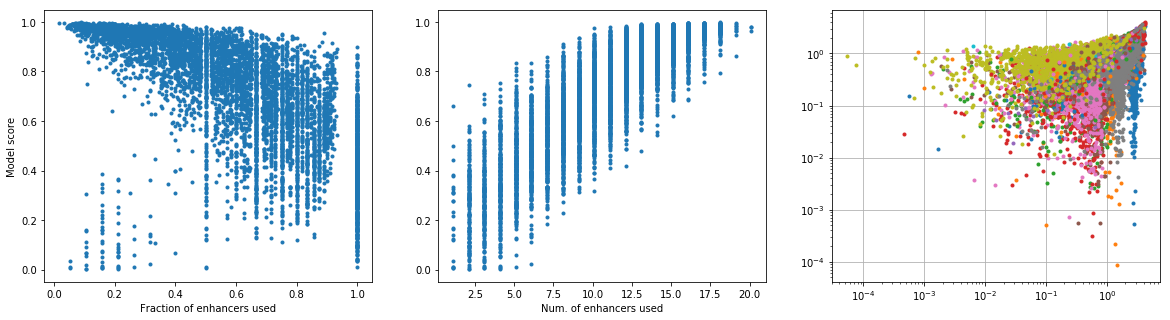

In [299]:
# plt.hist(mdl_score, bins=100);
W_nenh = (np.abs(W_enh_gene)>0).sum(axis=1)
W_pct_nenh = W_nenh / N_enh.squeeze()
W_nenh.shape, N_enh.shape, W_pct_nenh.shape

fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=False)
plt.sca(axs[0])
plt.plot(W_pct_nenh, mdl_score, '.')
plt.xlabel('Fraction of enhancers used')
plt.ylabel('Model score')

plt.sca(axs[1])
plt.plot(W_nenh+0.1, mdl_score, '.')
# plt.xscale('log')
plt.xlabel('Num. of enhancers used')

plt.sca(axs[2])
plt.loglog(y+1e-5, yhat+1e-5, '.');
plt.grid()

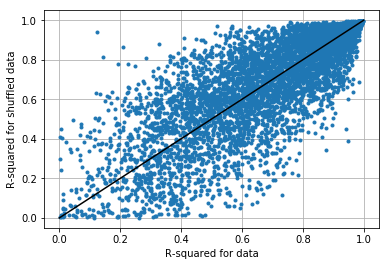

In [300]:
plt.plot(mdl_score, mdl_score_shuff, '.')
plt.plot([0,1],[0,1],'k')
plt.xlabel('R-squared for data')
plt.ylabel('R-squared for shuffled data')
plt.grid()

Text(0, 0.5, 'Spearman correlation')

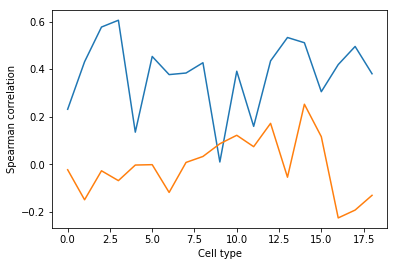

In [301]:
from scipy.stats import spearmanr 
cc = [spearmanr(y[:,i], yhat[:,i])[0] for i in range(ncells)]
cc_shuff = [spearmanr(y[:,i], yhat_shuff[:,i])[0] for i in range(ncells)]
plt.plot(cc)
plt.plot(cc_shuff)
plt.xlabel('Cell type')
plt.ylabel('Spearman correlation')

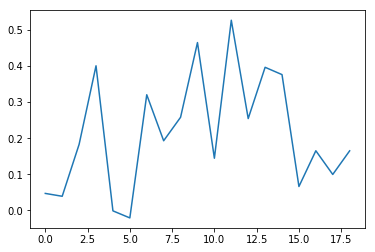

In [265]:
from scipy.stats import spearmanr 
cc = [spearmanr(y[:,i], yhat[:,i])[0] for i in range(ncells)]
plt.plot(cc)

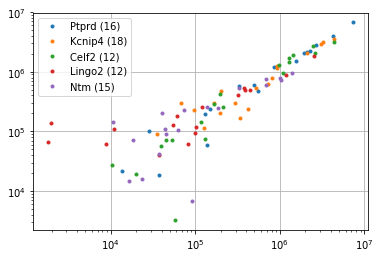

In [210]:
mdl_scorei = np.argsort(mdl_score.squeeze())[::-1]
mdl_scorei[:5]
for ensid in mdl_scorei[:5]:
    data = get_data_index([ensid])
    x = data['epi'].copy()
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T
    
    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    yhat = mdlf.predict(x)
    curr_nw = (mdlf.coef_!=0).sum()
    curr_gene = genes.loc[rnau.index[ensid],'gene']
    plt.loglog(data['y'].T, yhat, '.', label='%s (%d)' % (curr_gene,curr_nw))
plt.grid()
plt.legend()

In [158]:
mdlf.coef_.shape

(163,)

In [17]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
fn_load_prefix = 'RegressData/Regress_data_9868genes_21cells_'
fn_id = len(glob.glob('./RegressEnh*.pt'))+1 # Generate a unique ID for this run
fn_save = 'RegressEnh%0.4d_%s_N_%d_%d.%s.pt' % (fn_id, ('UseKmers' if use_kmers else 'NoKmers'), N1,N2,today)
fn_save, fn_id

('RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt', 24)

In [20]:
Nc = ml_lookup.shape[2]
def get_data_index(ensid_index):
    # For a list of ensids, return the x and y features
    Ng = len(ensid_index)
    mlu = ml_lookup[ensid_index,:,:] # Ngenes x Ne x Nc
    atacu = atac_lookup[ensid_index,:,:]
    if use_kmers:
        nz = np.max([len(kmeri_lookup[x]) for x in ensid_index])
        kmeru = np.zeros((Ng,nz,1,Nk))
        for i,ens in enumerate(ensid_index):
            kmeru[i,:len(kmeri_lookup[ens]),0,:] = kmer_countsu[kmeri_lookup[ens],:]
        kmeru = np.broadcast_to(kmeru, (Ng,nz,Nc,Nk))
    else:
        nz = np.sum((np.sum(atacu>0,axis=(0,2))+np.sum(mlu>0,axis=(0,2)))>0)
        kmeru = None

    # Keep only the enhancers that have data
    mlu = mlu[:,:nz,:,np.newaxis]
    atacu = atacu[:,:nz,:,np.newaxis]

    epi = np.concatenate((mlu,atacu),axis=3)
    y = rna_lookup[ensid_index,:]

#     # Test: add y to the input features
#     x[:,:,:,0] = y[:,np.newaxis,:]
    
#     # Testing:
#     for c in range(Nc):
#         y[:,c] = y[:,c]*0+c+0.123
    
    epi = torch.tensor(epi, dtype=torch.float)
    kmeru = torch.tensor(kmeru, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    
    return {'epi': epi, 'kmers': kmeru, 'y': y}

In [76]:
Nc = ml_lookup.shape[2]

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1_kmers = nn.Linear(Nk, N1);
        self.fc1_epi = nn.Linear(2, N1);
        self.fc2 = nn.Linear(3*N1, N2);
        self.fc3 = nn.Linear(N2, 1);
        
    def forward(self, epi, kmers):
        if kmers.shape[0]>1:
            x = F.relu(self.fc1_kmers(kmers) + self.fc1_epi(epi)) # In: N x Eg x C x (2+K), Out: N x Eg x C x N1
        else:
            x = F.relu(self.fc1_epi(epi))

        # Collapse across enhancers in different ways
        xmax = torch.max(x, 1)[0]       # Out: N x C x N1
        xmean = torch.mean(x, 1)       # Out: N x C x N1
        xsum = torch.sum(x, 1)/10000       # Out: N x C x N1
        x = torch.cat((xmax,xmean,xsum),2) # Out: N x C x 3*N1

        x = F.relu(self.fc2(x))       # Out: N x C x N2
#         x = torch.reshape(x,(-1,N2*Nc)) # Out: N x C
#         x = self.fc3(x)
        x = self.fc3(x)
        x = torch.reshape(x,(-1,Nc))
        
        return x

In [77]:
# Initialize
def myinit():
    global net, optimizer, criterion, scheduler, loss_test, loss_train, test, train, ensids
    net = Net()
    net.to(device)

    # Initialize the kmer weights to 0 and turn off learning
    net.fc1_kmers.requires_grad_(False)
    net.fc1_kmers.weight.fill_(0)
    net.fc1_kmers.bias.fill_(0)
    
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)
    
    loss_test=np.array([])
    loss_train = np.array([])

    # Train/Test split
    test = [c in ['chr10','chr12','chr14'] for c in rnau.join(genes)['chr']];
    train = [not i for i in test]

    test = np.random.permutation(np.nonzero(test)[0]).squeeze()
    train = np.random.permutation(np.nonzero(train)[0]).squeeze()
    ensids = rnau.index.values
    return

def train_epoch(epoch, phase=2):
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, LR=%3.5g, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                                        optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                        running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()

    return running_loss/nsamp

def test_epoch(epoch, phase=2):
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)

        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.detach().cpu().numpy())

    return running_loss_test/nsamp


In [78]:
# %load_ext line_profiler
# batch_size = 2
# %lprun -f get_data_index testfn()

In [79]:
# # %lprun -f get_data_index testfn()
# for batch_size in 2**np.arange(0,10):
#     print(batch_size)
#     myinit()
    
#     net.train()
#     %time testfn()

In [80]:
def test_net(indices):
    net.eval()
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(indices), batch_size):
        i = indices[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(i)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)

        outputs = net(batch_epi, batch_kmers)
        
        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.numpy())
    yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
    yyhat['y'] = np.concatenate(yyhat['y'],axis=0)
    
    cc = np.zeros((Nc,1))
    for i in range(yyhat['y'].shape[1]):
        cc[i,0] = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]    

    return yyhat, cc

def make_plot1(save=False):
    plt.figure(figsize=(15,4))
    plt.clf()
    plt.subplot(1,3,1)
    plt.semilogx(loss_train[2:],'o-',label='Train')
    plt.plot(loss_test[2:],'o-',label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(fn_save)

    plt.subplot(1,3,2)
    plt.plot(yyhat_test['y'].T, yyhat_test['yhat'].T,'.');
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True RNA expression')
    plt.ylabel('Estimated RNA expression')

    plt.subplot(1,3,3)
    try:
        ccu = np.stack(train_hist['cc'],axis=2)
        plt.plot(train_hist['epoch'], ccu[:,0,:].mean(axis=0), 'ko-', label='train')
        plt.plot(train_hist['epoch'], ccu[:,1,:].mean(axis=0), 'ro-', label='test')

        plt.ylabel('Correlation coef.')
        plt.xlabel('Epoch')
        plt.legend()
    except:
        print('Skipping cc plot')
        
    if save:
        fn_plot = 'Plots/'+fn_save.replace('.torch','')+'_corrcoef.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();
        
def make_plot2(save=False):
    plt.figure(figsize=(20,20))
    for i in range(Nc):
        plt.subplot(5,6,i+1)
        plt.plot([0,2],[0,2],'k--')
        plt.plot(yyhat_train['y'][:,i], yyhat_train['yhat'][:,i],'.');
        plt.plot(yyhat_test['y'][:,i], yyhat_test['yhat'][:,i],'.');
    #     cc = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]
        plt.title('r=%3.3f train/%3.3f test' % (cc[i,0], cc[i,1]))
    if save:
        fn_plot='Plots/'+fn_save.replace('.torch','')+'_scatter.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();


In [81]:
myinit()

Saved plot: Plots/RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt_corrcoef.png


<Figure size 432x288 with 0 Axes>

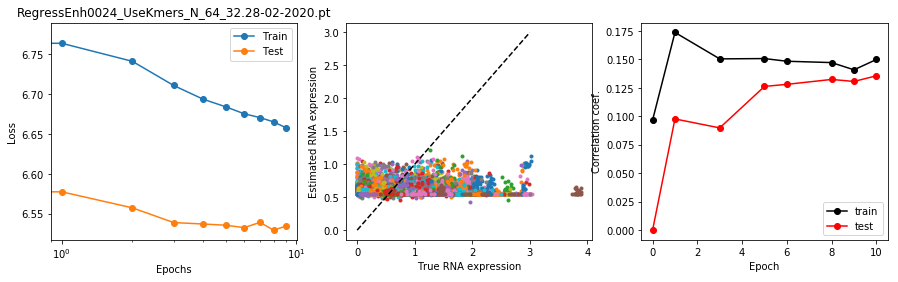

<Figure size 432x288 with 0 Axes>

In [ ]:
num_epochs1, num_epochs2 = 0, 200;

t0 = time.time()
batch_size = 2
train_hist = {'epoch': [], 'cc': []}
train_sample = random.sample(train.tolist(), 500)

for epoch in range(num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch, phase=1);
    loss_train = np.append(loss_train, new_loss_train)
    
    new_loss_test = test_epoch(epoch, phase=1);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)

    print('**** Phase1 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs1-1):        
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)
        
        if (epoch>0):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
        t0=time.time()
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


<Figure size 432x288 with 0 Axes>

Saved plot: Plots/RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt_corrcoef.png


<Figure size 432x288 with 0 Axes>

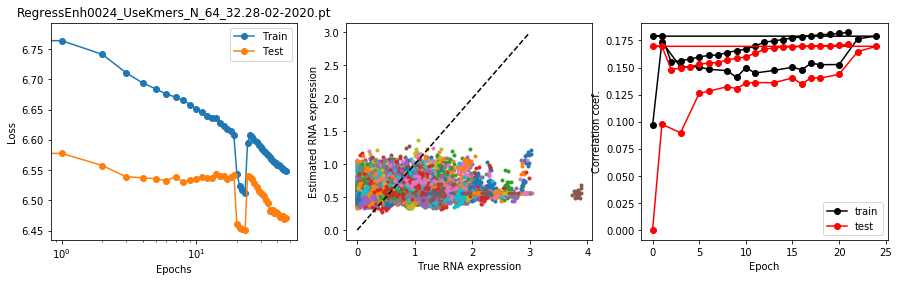

Saved data: RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt
Epoch 23, i=1886/8661, LR=0.002, loss=6.89721047, t=5.001, 0.00265 s/sample


In [ ]:
batch_size = 2
t0 = time.time()

# Turn on the learning for kmers
net.fc1_kmers.requires_grad_(True)
# Reset the learning rate for the optimizer
optimizer = optim.Adam(net.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)

for epoch in np.arange(num_epochs1, num_epochs2+num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch);
    loss_train = np.append(loss_train,new_loss_train)
    
    new_loss_test = test_epoch(epoch);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)


    print('**** Phase2 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs2-1):        
        if (epoch>1):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
            t0=time.time()
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)  
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


In [ ]:
break

In [ ]:
batch_size = 2;
cc = np.zeros((Nc,2))
yyhat_train, cc[:,[0]] = test_net(random.sample(train.tolist(), 500))
yyhat_test, cc[:,[1]] = test_net(test)
make_plot1(save=True)
make_plot2(save=True)  

In [ ]:
break
# N = 64 x 32
# **** Epoch 39, LR=1e-05, loss_train=0.00182151, loss_test=0.00199540, time = 0.15510 s/epoch
# **** Epoch 0, LR=0.002, loss_train=6.51633886, loss_test=5.99391724, time = 19.92587 s/epoch

# N = 32 x 8
# **** Epoch 53, LR=1e-07, loss_train=0.00180459, loss_test=0.00203680, time = 0.12214 s/epoch
# **** Epoch 71, LR=0.00025, loss_train=0.00172845, loss_test=0.00188889, time = 0.09076 s/epoch


# N = 32 x 16
# **** Epoch 85, LR=0.000, loss_train=0.00167278, loss_test=0.00183274, time = 0.07683 s/epoch
# **** Epoch 65, LR=1e-06, loss_train=0.00168914, loss_test=0.00189639, time = 0.09208 s/epoch
# **** Epoch 53, LR=5e-07, loss_train=0.00172672, loss_test=0.00198197, time = 0.10991 s/epoch
# **** Epoch 58, LR=0.0005, loss_train=0.00167136, loss_test=0.00189098, time = 0.11401 s/epoch

# N = 16 x 8
# **** Epoch 53, LR=1e-05, loss_train=0.00177558, loss_test=0.00194236, time = 0.11628 s/epoch

# N = 4 x 4
# **** Epoch 66, LR=1.5625e-05, loss_train=0.00180230, loss_test=0.00197317, time = 0.09088 s/epoch


In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
2